In [1]:
import json
import pandas as pd
from typing import List
from rxntools import reaction, utils
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem

In [6]:
from ergochemics import mapping
BRENDA_rxn = "CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]>>CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1"
rule2_SMARTS = "[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1>>[#6:3]1=[#6:8]-[#7+0:7]-[#6:6]=[#6:5]-[#6:4]-1.[#6:1]=[#8:2]"
rule3_SMARTS = "[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[#6:7]=[#8:8]>>[#6:7]-[#8:8].[#6:1]1:[#6:6]:[#6:5]:[#6:4]:[#7+:3]:[#6:2]:1"
mapped_operators = mapping.operator_map_reaction(rxn=BRENDA_rxn, operator=rule3_SMARTS)
print(mapped_operators.did_map)

False


In [4]:
reported_rxns_df = pd.read_parquet("../data/interim/enzymemap_MetaCyc_JN_mapped.parquet")
JN_rules_df = pd.read_csv('../data/raw/JN1224MIN_rules.tsv', delimiter='\t')

with open('../data/raw/cofactors.json') as f:
    cofactors_dict = json.load(f)

all_cofactor_codes: List[str] = list(cofactors_dict.keys())
cofactors_list: List[str] = [cofactors_dict[key] for key in cofactors_dict.keys()]
cofactors_df = pd.read_csv('../data/raw/all_cofactors.csv')


In [9]:
query_rule = 'rule0023'
radius = 1
include_stereo = True

# initialize a counter to keep track of the number of reactions from which rules were not extracted
rxns_skipped_count = 0

# extract the reaction SMARTS for this reaction under Joseph's rule as well as reactant and product codes
reactant_codes = JN_rules_df[JN_rules_df['Name']==query_rule]['Reactants'].to_list()[0]
product_codes = JN_rules_df[JN_rules_df['Name']==query_rule]['Products'].to_list()[0]
JN_rxn_SMARTS = JN_rules_df[JN_rules_df['Name']==query_rule]['SMARTS'].to_list()[0]

query_df = reported_rxns_df[reported_rxns_df['top_mapped_operator']==query_rule]
atom_mapped_rxns_list: List[str] = query_df['mapped'].to_list()
all_rxn_templates: List[str] = [] # initialize list to store all reaction templates extracted

# for each fully atom-mapped reaction
for rxn_SMARTS in atom_mapped_rxns_list:

    # create an instance of the reaction.mapped reaction class then extract atoms undergoing bond changes
    mapped_rxn = reaction.mapped_reaction(rxn_SMARTS) 
    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors=False, # set to False since we dont want changed cofactor atoms
                                                                                 consider_stereo=True,
                                                                                 cofactors_list=cofactors_list)
    
    substrates_list = mapped_rxn.get_substrates(cofactors_list=cofactors_list, consider_stereo=False)
    products_list = mapped_rxn.get_products(cofactors_list=cofactors_list, consider_stereo=False)
    lhs_cofactors_list = mapped_rxn.get_lhs_cofactors(cofactors_list=cofactors_list, consider_stereo=False)
    rhs_cofactors_list = mapped_rxn.get_rhs_cofactors(cofactors_list=cofactors_list, consider_stereo=False)

    # extract cofactor codes (leave out H+)
    lhs_cofactor_codes = [utils.get_cofactor_CoF_code(cofactor_smiles, cofactors_df) for cofactor_smiles in lhs_cofactors_list]
    rhs_cofactor_codes = [utils.get_cofactor_CoF_code(cofactor_smiles, cofactors_df) for cofactor_smiles in rhs_cofactors_list]

    lhs_cofactor_codes = [x for x in lhs_cofactor_codes if x!='H+']
    rhs_cofactor_codes = [x for x in rhs_cofactor_codes if x!='H+']

    # quick check to see if correct cofactor pairs are present according to JN1224MIN generalized reaction rules
    try:
        lhs_list = lhs_cofactor_codes
        rhs_list = [x for x in JN_rules_df[JN_rules_df['Name']==query_rule]['Reactants'].to_list()[0].split(';') if x.strip('_CoF') in all_cofactor_codes]
        assert Counter(lhs_list) == Counter(rhs_list)

        lhs_list = rhs_cofactor_codes
        rhs_list = [x for x in JN_rules_df[JN_rules_df['Name']==query_rule]['Products'].to_list()[0].split(';') if x.strip('_CoF') in all_cofactor_codes]
        assert Counter(lhs_list) == Counter(rhs_list)

        # initialize empty str to start building the reaction template for this rxn
        rxn_template = ''

        # check if reaction involves only a single substrate and single product
        if len(substrates_list)==1 and len(products_list)==1:
    
            # extract a template around the substrate
            substrate_template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts=substrates_list[0],
                                                                         reactive_atom_indices=list(changed_atoms),
                                                                         radius=radius,
                                                                         include_stereo=include_stereo)
        
            # atoms maps for different substrates can have different atom indices depending on order so we reset
            substrate_template = utils.reset_atom_map(substrate_template)
        
            rxn_template += substrate_template

            # add LHS cofactors to the template
            if lhs_cofactor_codes != []:
                for cofactor_code in lhs_cofactor_codes:
                    cofactor_SMARTS = utils.get_cofactor_SMARTS_from_JN_rule(cofactor_code=cofactor_code, 
                                                                            reactant_codes=reactant_codes, 
                                                                            product_codes=product_codes,
                                                                            rxn_SMARTS=JN_rxn_SMARTS,
                                                                            rxn_side='lhs')
                    
                    rxn_template += '.'
                    rxn_template += cofactor_SMARTS
                    
            # separator between LHS and RHS of rxn
            rxn_template += '>>' 
         
            # extract a template around the product
            product_template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts=products_list[0],                                           
                                                                       reactive_atom_indices=list(changed_atoms),
                                                                       radius=radius,
                                                                       include_stereo=include_stereo)
        
            # atom maps for different products can have different atom indices depending on order so we reset
            product_template = utils.reset_atom_map(product_template)
        
            rxn_template += product_template

            # add RHS cofactors the template
            if rhs_cofactor_codes != []:
                for cofactor_code in rhs_cofactor_codes:
                    cofactor_SMARTS = utils.get_cofactor_SMARTS_from_JN_rule(cofactor_code=cofactor_code, 
                                                                            reactant_codes=reactant_codes, 
                                                                            product_codes=product_codes,
                                                                            rxn_SMARTS=JN_rxn_SMARTS,
                                                                            rxn_side='rhs')
                    
                    rxn_template += '.'
                    rxn_template += cofactor_SMARTS
                    
            # try converting reaction template into a reaction object to ensure its valid
            AllChem.ReactionFromSmarts(rxn_template)

            all_rxn_templates.append(rxn_template) # store when finished

    except Exception as e:
        rxns_skipped_count += 1

[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not removing hydrogen atom without neighbors
[09:32:43] WARNING: not r

In [10]:
len(all_rxn_templates)

0

In [11]:
len(set(all_rxn_templates))

0

In [12]:
rxns_skipped_count

33

In [13]:
all_rxn_templates

[]

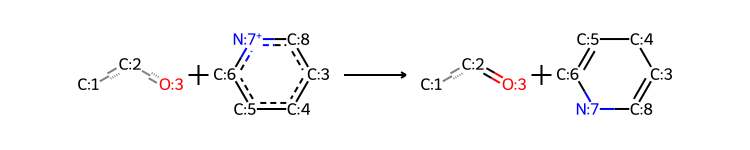

In [8]:
AllChem.ReactionFromSmarts('[C&H3:1][C&H2:2][O&H1:3].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1>>[C&H3:1][C&H1:2]=[O:3].[#6:3]1=[#6:8]-[#7+0:7]-[#6:6]=[#6:5]-[#6:4]-1')